In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Input,LSTM,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import Bidirectional

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
from tensorflow.keras.layers import Attention
from bs4 import BeautifulSoup

In [4]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv', delimiter=',',nrows=5000)
df.shape

(5000, 10)

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# Printing first example
print(df['Text'][0])
print()
print(df['Summary'][0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Good Quality Dog Food


## Dropping duplicate and NaN values

In [7]:
df.dropna(axis=0,inplace=True)
df.drop_duplicates(subset=['Text'],inplace=True)

## Preprocessing

In [8]:
astrophe_words = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [9]:
def astrophe_preprocess(text):
    l = []
    for txt in text.split(" "):
        if txt in set(astrophe_words.keys()):
            l.append(astrophe_words[txt])
        
        else:
            l.append(txt)
    
    out = " ".join(l)
    return out

In [10]:
len(df['Text'])

4984

In [11]:
# Code to check if HTML tags are present or not
def has_html_tags(text):
    # Regular expression pattern to match HTML tags
    html_tag_pattern = r'<[^>]+>'
    
    for i in range(len(text)):
        # Search for the first occurrence of an HTML tag in the text
        match = re.search(html_tag_pattern, text[i])
        
        if match is not None:
            print(i)
            return True
    
    return False

print(has_html_tags(text = df['Text']))

10
True


In [12]:
df['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [13]:
out = BeautifulSoup(df['Text'][10], "lxml").text
out

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.Thank you for the personal, incredible service!"

In [14]:
def text_preprocess(text):
    t = text.lower()
    # Getting text from HTML tags
    t = BeautifulSoup(t, "lxml").text
    
    # Remove all text within parenthesis
    t = re.sub(r'\([^)]*\)', '', t)
    
    # Remove " 
    t = re.sub('"','',t)
    
    # Change astrophe words
    t = astrophe_preprocess(t) 
    
    # Remove 's
    t = re.sub(r"'s\b","",t)
    
    # Replacing all non-alphabetic characters
    t = re.sub("[^a-zA-Z]", " ", t) 
    
    return t.strip()

In [15]:
cleaned_text = []
for txt in df['Text']:
    cleaned_text.append(text_preprocess(txt))

In [16]:
cleaned_text[10]

'i do not know if it is the cactus or the tequila or just the unique combination of ingredients  but the flavour of this hot sauce makes it one of a kind   we picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away   when we realized that we simply could not find it anywhere in our city we were bummed now  because of the magic of the internet  we have a case of the sauce and are ecstatic because of it if you love hot sauce  i mean really love hot sauce  but do not want a sauce that tastelessly burns your throat  grab a bottle of tequila picante gourmet de inclan   just realize that once you taste it  you will never want to use any other sauce thank you for the personal  incredible service'

In [17]:
import spacy

# Load the English language model for spaCy
nlp = spacy.load("en_core_web_sm")

def lemmatize_sentence(sentence):
    # Process the sentence using spaCy
    doc = nlp(sentence)
    
    # Lemmatize each word in the sentence and join them back
    lemmatized_sentence = ' '.join(token.lemma_ for token in doc)
    
    return lemmatized_sentence

# Example
sentence = "The quick brown foxes are jumping over the lazy dogs"
lemmatized_sentence = lemmatize_sentence(sentence)
print(lemmatized_sentence)

the quick brown fox be jump over the lazy dog


In [18]:
final_text = []
for txt in cleaned_text:
    final_text.append(lemmatize_sentence(txt))

In [19]:
len(final_text)

4984

### Summary Preprocessing

In [20]:
df['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [21]:
def summary_cleaner(text):
    t = re.sub('"','', text)
    t = astrophe_preprocess(t)    
    t = re.sub(r"'s\b","",t)
    t = re.sub("[^a-zA-Z]", " ", t)
    t = t.lower()
    t = t.split()
    
    newString=''
    
    for i in t:
        if len(i)>1:                                 
            newString=newString+i+' '  
    
    return newString

#Call the above function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [22]:
df['cleaned_text']= final_text
df['cleaned_summary']=cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [23]:
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [24]:
# Printing few examples of Data
for i in range(5):
    print("Review:",df['cleaned_text'][i])
    print("Summary:",df['cleaned_summary'][i])
    print()

Review: I have buy several of the vitality can dog food product and have find they all to be of good quality   the product look more like a stew than a process meat and it smell well   my labrador be finicky and she appreciate this product well than   most
Summary: _START_ good quality dog food  _END_

Review: product arrive label as jumbo salt peanut    the peanut be actually small sized unsalted   not sure if this be an error or if the vendor intend to represent the product as jumbo
Summary: _START_ not as advertised  _END_

Review: this be a confection that have be around a few century    it be a light   pillowy citrus gelatin with nut    in this case filbert   and it be cut into tiny square and then liberally coat with powdered sugar    and it be a tiny mouthful of heaven    not too chewy   and very flavorful    I highly recommend this yummy treat    if you be familiar with the story of c s   lewis   the lion   the witch   and the wardrobe    this be the treat that seduce edmund in

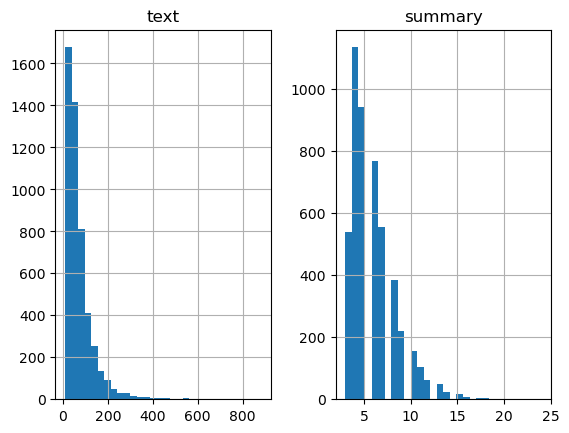

In [25]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [26]:
max_in_len =400  # Max text length chosen based on distribution
max_tr_len =20   # Max summary length

In [27]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.2,random_state=0,shuffle=True)

# Seq2Seq Model

### Text Tokenizer

In [28]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()            # Text tokenizer
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()           # Summary tokenizer
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

### Padding and Preprocessing data ( for encoder and decoder )

In [29]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')
 
#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [30]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
num_in_words = len(in_tokenizer.word_index) +1
num_tr_words = len(tr_tokenizer.word_index) +1

In [32]:
# Encoder: We will initialize the encoder input tensor using the ‘Input’ object.
# The expected shape of the batch will be 100 (maximum input length)-dimensions. Then we will create an 
#‘Embedding Layer’ which will have the total number of input words as the first argument and a shape of 500 which is the latent(hidden) dimension.
from keras import backend as K
K.clear_session() 
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words , latent_dim)(en_inputs) 


#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
# The LSTM layer will capture all the contextual information present in the input sequence. 
# We will return hidden state output and also states i.e. hidden state and cell state after execution of every LSTM layer.
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]


# Decoder: Like Encoder we will initialize the decoder input tensor and then pass it to the only LSTM. 
# Here, the decoder will also have the initial state where we will pass the hidden state and 
# cell state values that we have obtained from the encoder’s LSTM layer. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words , latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 


#Attention layer: We will pass the encoder and decoder outputs into the attention layer and then 
#we will concatenate attention layer outputs with the decoder outputs.

attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

#We will pass the encoder and decoder outputs into the attention layer and then we will concatenate attention layer outputs with the decoder outputs.

#Dense layer (output layer)
dec_dense = Dense(num_tr_words, activation='softmax') 
dec_outputs = dec_dense(merge) 


#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 400, 500)     4632500     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 400, 500),   2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [33]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 

In [34]:
history = model.fit( 
                    [en_in_data, dec_in_data],
                    dec_tr_data, 
                    batch_size=512, 
                    epochs=50, 
                    validation_split=0.1,
                    )

Epoch 1/50
8/8 [==============================] - 23s 2s/step - loss: 4.3230 - accuracy: 0.6360 - val_loss: 1.8078 - val_accuracy: 0.7423
Epoch 2/50
8/8 [==============================] - 11s 1s/step - loss: 1.7450 - accuracy: 0.7509 - val_loss: 1.6952 - val_accuracy: 0.7599
Epoch 3/50
8/8 [==============================] - 11s 1s/step - loss: 1.6499 - accuracy: 0.7549 - val_loss: 1.6583 - val_accuracy: 0.7532
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 1.6125 - accuracy: 0.7592 - val_loss: 1.6213 - val_accuracy: 0.7648
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 1.5561 - accuracy: 0.7709 - val_loss: 1.5691 - val_accuracy: 0.7674
Epoch 6/50
8/8 [==============================] - 11s 1s/step - loss: 1.4973 - accuracy: 0.7729 - val_loss: 1.5320 - val_accuracy: 0.7955
Epoch 7/50
8/8 [==============================] - 11s 1s/step - loss: 1.4636 - accuracy: 0.7967 - val_loss: 1.4992 - val_accuracy: 0.7879
Epoch 8/50
8/8 [==================

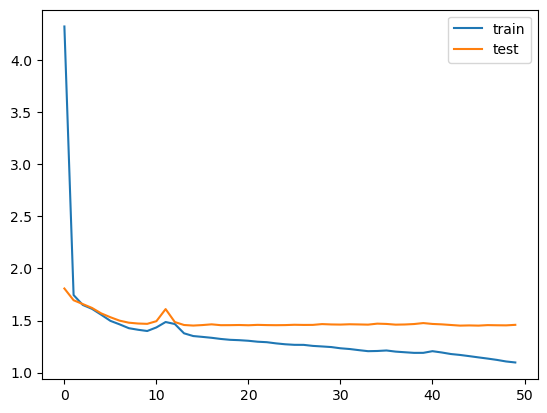

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

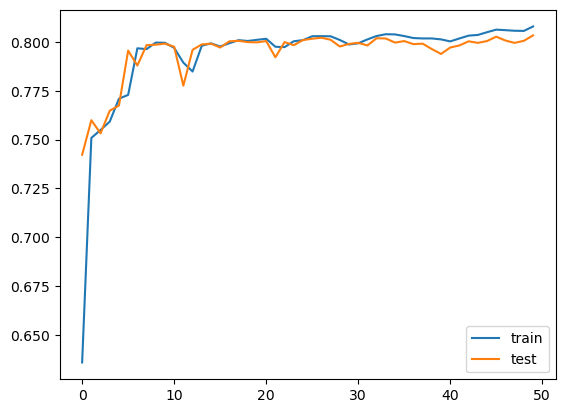

In [36]:
plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='test') 
plt.legend() 
plt.show()

In [37]:
model.save('/kaggle/working/model_5k')

## Inference

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras import models
# encoder inference
latent_dim=500

model = models.load_model("/kaggle/working/model_5k")

#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
#en_states=[state_h_enc,state_c_enc]

#add input and state from the layer.
en_model = Model(inputs = model.input[0],outputs = [en_outputs, state_h_enc, state_c_enc])

###################################################################################################

# decoder inference
#create Input object for hidden and cell state for decoder shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_embedding= dec_emb_layer(dec_inputs)
 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
dec_lstm = model.layers[7]
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

####################################################################################################

#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

####################################################################################################

#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)

####################################################################################################
 
# Finally define the Model Class
dec_model = Model(
                    inputs = [dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
                    outputs = [dec_outputs2] + [state_h2, state_c2]
                 )

In [39]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_target_word_index[0]=' '

reverse_source_word_index = in_tokenizer.index_word

#create a dictionary with a key as words and value as index.
target_word_index = tr_tokenizer.word_index

In [40]:
def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)
 
    #target sequence with initial word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['start']
 
    #if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "
        
        # Exit condition: either hit max length or find a stop word or last word.
        if text_word == "end" or len(decoded_sentence) > max_tr_len:
            stop_condition = True
        
        #update target sequence to the current word index since we are in a loop.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c

    #return the decoded sentence
    return decoded_sentence

In [41]:
def print_output(test_input, test_output):
    txt = text_preprocess(test_input)
    txt = lemmatize_sentence(txt)
    
    inp_x= in_tokenizer.texts_to_sequences([txt]) 
    inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')
    
    summary = decode_sequence(inp_x.reshape(1,max_in_len))
    
    print("Review: " , test_input)
    print()
    print("Original Summary: ", test_output[1:-1])
    print()
    print("Predicted Output: ", summary[:-1])

In [43]:
x_val.iloc[10]

'these be beautiful   smooth spring roll wrapper and on the package label there be a sticker on each one that read   new technology   so   I be figure by the bad review that this company change the way they manufacture their spring roll wrapper and have probably up their quality control as well   I be nervous about order these by the bad review but I be glad I take a chance because these be a bargain compare to some of the other brand will definitely order these again'

In [45]:
print_output(test_input= x_val.iloc[10], test_output = y_val.iloc[10])

1/1 [==============================] - 0s 23ms/step
Review:  these be beautiful   smooth spring roll wrapper and on the package label there be a sticker on each one that read   new technology   so   I be figure by the bad review that this company change the way they manufacture their spring roll wrapper and have probably up their quality control as well   I be nervous about order these by the bad review but I be glad I take a chance because these be a bargain compare to some of the other brand will definitely order these again

Original Summary:  START_ great quality  _END

Predicted Output:  great end


In [46]:
print_output(test_input= x_val.iloc[25], test_output = y_val.iloc[25])

1/1 [==============================] - 0s 21ms/step
Review:  this stevia be the good tasting we have ever try   it also mix into beverage more thoroughly than some other the service from this buyer be prompt   the product arrive on time and in excellent condition   would order from they again   and recommend they to other linda blyth

Original Summary:  START_ the best stevia  _END

Predicted Output:  great for the money end
